## Notebook to organize the data from the CTs

## Note: 
- this would process every volume in the dataset (which could take a long time)
- with all the file and dirs handling there should be checks if the folders or files are already created or bla bla bla

In [1]:
import torch
import torch.utils.data
from matplotlib import pyplot as plt
import SimpleITK as sitk
import os
import ReadWriteXML as rw
import numpy as np
import pandas as pd

In [2]:
#directory with all the volumes
#volumes_dir = r'C:\Users\Juanig\Desktop\Desktop_\ct images'
volumes_dir = r'C:\Users\Juan Pisula\Desktop\ct_images\patches'
#directory with the ground truth files
gt_dir = os.path.join(volumes_dir, 'Ground Truth')
#directory with the lo res files
lr_dir = os.path.join(volumes_dir, 'Low resolution')

### Lets extract smaller patches out of every volume. 

In [3]:
#extract patches of v*v*v with a stride of s and return a list of numpy arrays with them
def extract_patches(nparray, v = 55, s = 10):
    patches_list = []
    for i in range(v - 1, nparray.shape[0] + s, s):
        for j in range (v - 1, nparray.shape[1] + s, s):
            for k in range(v - 1, nparray.shape[2] + s, s):

                i_max = min(i, nparray.shape[0] - 1)
                j_max = min(j, nparray.shape[1] - 1)
                k_max = min(k, nparray.shape[2] - 1)
                i_min, j_min, k_min = i_max -(v-1), j_max -(v-1), k_max -(v-1)

                patch = np.zeros([v, v, v])
                patch[0:v, 0:v, 0:v] = nparray[i_min:(i_max+1), j_min:(j_max+1), k_min:(k_max+1)]
                patches_list.append(patch)     
    
    return patches_list

#open a .xml volume and extract the patches   
def open_volume_and_extract (file_path):
    itk_volume = rw.OpenXML(file_path, kind = 'Slices')
    np_volume = sitk.GetArrayFromImage(itk_volume)
    patches = extract_patches(np_volume)
    return patches

#True if the patch does not contain any NaN value
def is_valid_patch(patch):
    result = not (np.any(np.isnan(patch)))
    return result

#Save a list of patches if they are valid
def save_patches (patches, new_dir):       
    i = 0
    for patch in patches:
        if is_valid_patch(patch):
            #remember, patch is a numpy array!
            #and their filename is an integer:
            #the corresponding hi res patch of a lo res pair would have the same file name! (and stored in a different directory)
            torch.save(patch, os.path.join(new_dir, str(i) + '.pt'))
        i += 1    
    


#### Some low res volume patches have NaN values on it corresponding to a border, this wouldnt make representative data



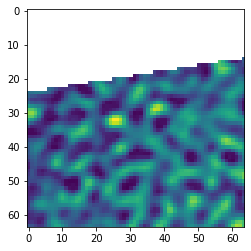

In [4]:
test = rw.OpenXML(os.path.join(lr_dir, '5a_100_FBPPhil_Scan1Slices.xml'), kind = 'Slices' )
test_np = sitk.GetArrayFromImage(test)
test_patches = extract_patches(test_np) 
#test_patches = torch.FloatTensor(test_patches)
plt.imshow(test_patches[0][0][:][:])
plt.show()

# Processing the _ground truth_ volumes 

#### These are the files to process

In [4]:
#every file in the directory gt_dir
gt_files = [f for f in os.listdir(gt_dir) if os.path.isfile(os.path.join(gt_dir, f))]
gt_files = list(filter(lambda x: 'Slices.xml' in x, gt_files))
gt_files

['5a_500FBPMedianSlices.xml',
 '5a_XCTSlices.xml',
 '5b_500FBPMedianSlices.xml',
 '5b_XCTSlices.xml',
 '6c_500FBPMedianSlices.xml',
 '6c_XCTSlices.xml',
 '8b_500FBPMedianSlices.xml',
 '8b_XCTSlices.xml',
 'V8_500FBPMedianSlices.xml',
 'V8_XCTSlices.xml']

In [5]:
gt_patches_dir = os.path.join(volumes_dir, 'Ground Truth patches')

if not os.path.exists(gt_patches_dir):
    os.makedirs(gt_patches_dir)

for f in gt_files:                    
    new_dir = os.path.join(gt_patches_dir, f.replace('.xml', ''))
    if not os.path.exists(new_dir):
        os.makedirs(new_dir)
    patches = open_volume_and_extract(os.path.join(gt_dir, f))
    save_patches(patches, new_dir)

# Processing all the _low resolution_ volumes


In [4]:
lo_res_config = '100_FBPPhil'
hi_res_config = '500FBP' #'XCT'

lr_files = [f for f in os.listdir(lr_dir) if os.path.isfile(os.path.join(lr_dir,f))]
lr_files = list(filter(lambda x: lo_res_config in x, lr_files)) 
lr_files

['5a_100_FBPPhil_Scan1Slices.xml',
 '5a_100_FBPPhil_Scan2Slices.xml',
 '5a_100_FBPPhil_Scan3Slices.xml',
 '5b_100_FBPPhil_Scan1Slices.xml',
 '5b_100_FBPPhil_Scan2Slices.xml',
 '5b_100_FBPPhil_Scan3Slices.xml',
 '6c_100_FBPPhil_Scan1Slices.xml',
 '6c_100_FBPPhil_Scan2Slices.xml',
 '6c_100_FBPPhil_Scan3Slices.xml',
 '8b_100_FBPPhil_Scan1Slices.xml',
 '8b_100_FBPPhil_Scan2Slices.xml',
 '8b_100_FBPPhil_Scan3Slices.xml',
 'V8_100_FBPPhil_Scan1Slices.xml',
 'V8_100_FBPPhil_Scan2Slices.xml',
 'V8_100_FBPPhil_Scan3Slices.xml']

In [5]:
lr_patches_dir = os.path.join(volumes_dir, 'Low resolution patches')

if not os.path.exists(lr_patches_dir) :
    os.makedirs(lr_patches_dir)

for f in lr_files:
    new_dir = os.path.join(lr_patches_dir, f.replace('.xml', ''))
    if not os.path.exists(new_dir):
        os.makedirs(new_dir)       
    patches = open_volume_and_extract(os.path.join(lr_dir, f))
    save_patches(patches, new_dir)

# Making a .csv with the directories of the low res patches and their corresponding hi res patches

In [6]:
#make a pandas dataframe with all the files in the input directories
def patches_to_dataframe(lo_res_dir, high_res_dir):
    #list with every file (patch) in the lo_res_dir
    lo_res_files = os.listdir(lo_res_dir)
    pairs = []
    #for every patch in the folder lo_res_dir
    for file in lo_res_files:
        #directory of the lo res patch
        lo_res_file_dir = os.path.join(lo_res_dir, file)
        #directory where the ground truth patch should be
        hi_res_file_dir = os.path.join(high_res_dir, file)
        #if the file exists, append to the list
        if os.path.exists ( hi_res_file_dir ):
            pairs.append( (lo_res_file_dir, hi_res_file_dir) )
    #make the dataframe
    df_out = pd.concat( [ pd.DataFrame( [ [ pair[0], pair[1] ] ], columns=['Lo Res Patch', 'Hi Res Patch']) for pair in pairs] ,ignore_index=True)            
    return df_out

#recursive function to get a list of dataframes 
#the input arg is a list of pairs (tuples) of the lo res patches directory and their corresponding hi res patches directory =
def _files_to_csv(dirs_list):
    if len(dirs_list) == 1:
        pair = dirs_list.pop(0)
        return [ patches_to_dataframe( pair[0], pair[1]  ) ]
    else:
        pair = dirs_list.pop(0)
        recursive_case = _files_to_csv(dirs_list)
        recursive_case.append( patches_to_dataframe( pair[0], pair[1]  ) )
        return recursive_case
    
#make a .csv with the directories of the pairs of patches 
#lo_res_config can be, for example: '100_FBPPhil'
#hi_res config can be, for example: '500FBP'
def make_csv_for_dataset(volumes_dir, lo_res_config, hi_res_config ):
    lr_dir = os.path.join(volumes_dir, 'Low resolution patches')
    gt_dir = os.path.join(volumes_dir, 'Ground Truth patches')   
    
    #get the directories of the desired patches 
    lr_dirs = [f for f in os.listdir(lr_dir) if os.path.isdir(os.path.join(lr_dir,f))]
    lr_dirs = list(filter(lambda x: lo_res_config in x, lr_dirs)) 
    
    gt_dirs = [f for f in os.listdir(gt_dir) if os.path.isdir(os.path.join(gt_dir,f))]
    gt_dirs = list(filter(lambda x: hi_res_config in x, gt_dirs))
    
    pairs = []

    for lr_folder in lr_dirs:
        #string with the "patient"
        patient = lr_folder.split('_',1)[0]
        #get the folder of the corresponding ground truth volume for that patient
        gt_folder = list(filter(lambda x: patient in x, gt_dirs))[0]
        #make the tuple with the pair of dirs
        pair = ( os.path.join(lr_dir,lr_folder), os.path.join(gt_dir, gt_folder)   )
        #append to list
        pairs.append(pair)
     
    #get the list of dataframes
    dataframes = _files_to_csv(pairs)  
    #concatenate dataframes
    csv = pd.concat(dataframes , ignore_index = True)
    #save as .csv
    csv_name = lo_res_config + '_' + hi_res_config + '.csv'
    csv_dir = os.path.join(volumes_dir, csv_name)
    csv.to_csv(csv_dir, index = False)
    return csv

In [7]:
csv = make_csv_for_dataset(volumes_dir, lo_res_config, hi_res_config)

In [22]:
i = 11000
print(csv.iloc[i]['Lo Res Patch'])
print(csv.iloc[i]['Hi Res Patch'])

C:\Users\Juan Pisula\Desktop\ct_images\patches\Low resolution patches\8b_100_FBPPhil_Scan1Slices\1349.pt
C:\Users\Juan Pisula\Desktop\ct_images\patches\Ground Truth patches\8b_500FBPMedianSlices\1349.pt


In [23]:
csv


,Lo Res Patch,Hi Res Patch
0,C:\Users\Juan Pisula\Desktop\ct_images\patches...,C:\Users\Juan Pisula\Desktop\ct_images\patches...
1,C:\Users\Juan Pisula\Desktop\ct_images\patches...,C:\Users\Juan Pisula\Desktop\ct_images\patches...
2,C:\Users\Juan Pisula\Desktop\ct_images\patches...,C:\Users\Juan Pisula\Desktop\ct_images\patches...
3,C:\Users\Juan Pisula\Desktop\ct_images\patches...,C:\Users\Juan Pisula\Desktop\ct_images\patches...
4,C:\Users\Juan Pisula\Desktop\ct_images\patches...,C:\Users\Juan Pisula\Desktop\ct_images\patches...
...,...,...
32627,C:\Users\Juan Pisula\Desktop\ct_images\patches...,C:\Users\Juan Pisula\Desktop\ct_images\patches...
32628,C:\Users\Juan Pisula\Desktop\ct_images\patches...,C:\Users\Juan Pisula\Desktop\ct_images\patches...
32629,C:\Users\Juan Pisula\Desktop\ct_images\patches...,C:\Users\Juan Pisula\Desktop\ct_images\patches...
32630,C:\Users\Juan Pisula\Desktop\ct_images\patches...,C:\Users\Juan Pisula\Desktop\ct_images\patches...
